<font size="+3">Cell Towers</font>

In [1]:
import duckdb
import pandas as pd
import polars as pl
import altair as alt
alt.data_transformers.enable("vegafusion")
from vega_datasets import data


# Data

In [2]:
duckdb.sql("SELECT * FROM 'cell_towers.csv.zst' LIMIT 10;")

┌─────────┬───────┬───────┬───────┬───────┬───┬────────────┬─────────────────────┬─────────────────────┬───────────────┐
│  radio  │  mcc  │  net  │ area  │ cell  │ … │ changeable │       created       │       updated       │ averageSignal │
│ varchar │ int64 │ int64 │ int64 │ int64 │   │   int64    │      timestamp      │      timestamp      │     int64     │
├─────────┼───────┼───────┼───────┼───────┼───┼────────────┼─────────────────────┼─────────────────────┼───────────────┤
│ CDMA    │   250 │  1005 │ 45148 │ 25455 │ … │          1 │ 2017-09-13 04:51:56 │ 2017-09-13 19:10:22 │             0 │
│ CDMA    │   250 │  1005 │ 45148 │ 25452 │ … │          1 │ 2017-09-13 04:59:05 │ 2017-09-13 04:59:05 │             0 │
│ CDMA    │   250 │  1005 │ 45148 │ 25451 │ … │          1 │ 2017-09-13 14:11:57 │ 2017-09-13 19:11:53 │             0 │
│ CDMA    │   250 │  1005 │ 45148 │ 25456 │ … │          1 │ 2017-09-13 15:03:32 │ 2017-09-13 15:03:32 │             0 │
│ CDMA    │   250 │  1005 │ 3720

In [3]:
duckdb.sql("""
CREATE TABLE towers AS 
FROM read_csv(
    'cell_towers.csv.zst',
    types = {
        'radio': 'varchar',
        'mcc': 'USMALLINT',
        'net': 'USMALLINT',
        'area': 'USMALLINT',
        'cell': 'UBIGINT',
        'unit': 'SMALLINT',
        'lon': 'DOUBLE',
        'lat': 'DOUBLE',
        'range': 'UINTEGER',
        'samples': 'UINTEGER',
        'changeable': 'UTINYINT',
        'created': 'TIMESTAMP',
        'updated': 'TIMESTAMP',
        'averageSignal': 'UTINYINT'
        }
    );
""")

In [4]:
duckdb.sql("""
CREATE TABLE mcc AS 
FROM read_csv(
    'mcc-mnc.csv',
    sep=';',
    types = {
        'MCC': 'USMALLINT',
        'MNC': 'USMALLINT',
        'PLMN': 'UINTEGER',
        'Region': 'VARCHAR',
        'Country': 'VARCHAR',
        'ISO': 'VARCHAR',
        'Operator': 'VARCHAR',
        'Brand': 'VARCHAR',
        'TADIG': 'VARCHAR',
        'Bands': 'VARCHAR'
        }
    );
""")

In [5]:
duckdb.sql("SELECT * FROM mcc LIMIT 10;")

┌────────┬────────┬────────┬──────────────────────┬───┬────────────┬─────────┬──────────────────────┐
│  MCC   │  MNC   │  PLMN  │        Region        │ … │   Brand    │  TADIG  │        Bands         │
│ uint16 │ uint16 │ uint32 │       varchar        │   │  varchar   │ varchar │       varchar        │
├────────┼────────┼────────┼──────────────────────┼───┼────────────┼─────────┼──────────────────────┤
│    901 │     27 │  90127 │ Worldwide            │ … │ OnMarine   │ AAMOM   │ GSM 1800             │
│    242 │     99 │  24299 │ Europe               │ … │ NULL       │ AAMT1   │ LTE 800 / LTE 1800   │
│    363 │      2 │  36302 │ North America and …  │ … │ Digicel    │ ABWDC   │ GSM 900 / GSM 1800…  │
│    412 │     40 │  41240 │ Asia and the Middl…  │ … │ MTN        │ AFGAR   │ GSM 900 / GSM 1800…  │
│    412 │      1 │  41201 │ Asia and the Middl…  │ … │ AWCC       │ AFGAW   │ GSM 900 / GSM 1800…  │
│    412 │     50 │  41250 │ Asia and the Middl…  │ … │ Etisalat   │ AFGEA   │ GSM

In [6]:
duckdb.sql("SELECT count(*) FROM towers;")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│     43276150 │
└──────────────┘

# Exploration

In [7]:
duckdb.sql("""
SELECT
    radio,
    count(*) AS nrows,
    to_timestamp(avg(epoch(created))) AS created,
    to_timestamp(avg(epoch(updated))) AS updated,
FROM towers
GROUP BY ALL
ORDER BY nrows DESC
""")

┌─────────┬──────────┬───────────────────────────────┬───────────────────────────────┐
│  radio  │  nrows   │            created            │            updated            │
│ varchar │  int64   │   timestamp with time zone    │   timestamp with time zone    │
├─────────┼──────────┼───────────────────────────────┼───────────────────────────────┤
│ UMTS    │ 20686487 │ 2016-01-23 22:50:50.471735-06 │ 2016-08-05 10:00:22.713292-05 │
│ LTE     │ 12101148 │ 2017-04-11 01:42:47.54504-05  │ 2017-12-31 18:49:07.819699-06 │
│ GSM     │  9931304 │ 2015-04-21 21:48:09.8565-05   │ 2016-04-19 14:03:33.724524-05 │
│ CDMA    │   556344 │ 2013-07-23 20:11:02.967056-05 │ 2013-11-02 19:39:47.447328-05 │
│ NR      │      867 │ 2020-10-13 19:41:52.897347-05 │ 2020-11-05 12:55:56.346021-06 │
└─────────┴──────────┴───────────────────────────────┴───────────────────────────────┘

In [8]:
duckdb.sql("""
SELECT
    t.mcc,
    country,
    region,
    count(*) AS nrows,
    to_timestamp(avg(epoch(created))) AS created,
    to_timestamp(avg(epoch(updated))) AS updated,
FROM towers t
INNER JOIN (
    SELECT mcc.mcc, country, region
    FROM mcc
    GROUP BY ALL
) m
ON t.mcc = m.mcc
WHERE radio = 'NR'
GROUP BY ALL
ORDER BY nrows DESC
LIMIT 20
""")

┌────────┬──────────────────────┬──────────────────────┬───────┬───────────────────────┬───────────────────────────────┐
│  mcc   │       Country        │        Region        │ nrows │        created        │            updated            │
│ uint16 │       varchar        │       varchar        │ int64 │ timestamp with time…  │   timestamp with time zone    │
├────────┼──────────────────────┼──────────────────────┼───────┼───────────────────────┼───────────────────────────────┤
│    286 │ Turkey               │ Europe               │   349 │ 2020-09-06 23:59:14…  │ 2020-10-11 13:05:14.962751-05 │
│    262 │ Germany              │ Europe               │   172 │ 2020-12-26 13:37:32…  │ 2021-01-01 11:30:23.517442-06 │
│    310 │ Guam (USA)           │ North America and …  │   113 │ 2020-09-06 14:17:20…  │ 2020-09-29 04:09:04.017699-05 │
│    310 │ Northern Mariana I…  │ North America and …  │   113 │ 2020-09-06 14:17:20…  │ 2020-09-29 04:09:04.017699-05 │
│    310 │ United States of A…  

In [9]:
duckdb.sql("""
SELECT
    mcc,
    count(*) AS nrows,
    MAX(created) AS max_created,
    MAX(updated) AS max_updated,
FROM towers
WHERE radio = 'NR'
GROUP BY ALL
ORDER BY nrows DESC
LIMIT 20
""")

┌────────┬───────┬─────────────────────┬─────────────────────┐
│  mcc   │ nrows │     max_created     │     max_updated     │
│ uint16 │ int64 │      timestamp      │      timestamp      │
├────────┼───────┼─────────────────────┼─────────────────────┤
│    286 │   349 │ 2020-12-22 12:00:02 │ 2021-02-14 00:00:03 │
│    262 │   172 │ 2021-02-17 12:00:06 │ 2021-02-17 12:00:09 │
│    310 │   113 │ 2021-02-16 15:55:50 │ 2021-02-16 20:37:27 │
│    208 │    50 │ 2021-02-01 13:17:30 │ 2021-02-01 13:17:30 │
│    505 │    46 │ 2021-01-24 04:12:59 │ 2021-02-17 02:17:11 │
│    214 │    38 │ 2021-01-16 00:00:08 │ 2021-01-16 00:00:08 │
│    260 │    16 │ 2020-12-12 14:34:37 │ 2020-12-12 14:35:07 │
│    302 │    13 │ 2020-12-14 20:44:22 │ 2021-02-09 13:16:16 │
│    234 │    12 │ 2021-02-02 21:49:55 │ 2021-02-02 21:49:55 │
│    244 │    12 │ 2020-12-23 08:39:36 │ 2020-12-26 14:35:48 │
│    404 │    11 │ 2021-01-14 08:53:27 │ 2021-01-14 08:53:27 │
│    250 │     9 │ 2021-02-09 10:39:24 │ 2021-02-16 16:

# NR towers en each country

In [10]:
countries = alt.topo_feature(data.world_110m.url, 'countries')

background = alt.Chart(countries).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project(
    "equirectangular"
).properties(
    width=900,
    height=600
)

points = alt.Chart(
    duckdb.sql("""
    SELECT
        mcc,
        radio,
        lat,
        lon,
    FROM towers t
    WHERE radio = 'NR'
    """).df()
).mark_circle().encode(
    longitude='lon:Q',
    latitude='lat:Q',
    size=alt.value(10),
    tooltip='mcc',
    color='radio'
)

background + points

alt.LayerChart(...)

# Global cell tower locations

In [11]:
import matplotlib.pyplot as plt
import datashader as ds
import datashader.transfer_functions as tf
import colorcet as cc
from datashader.utils import lnglat_to_meters
import matplotlib.patches as mpatches

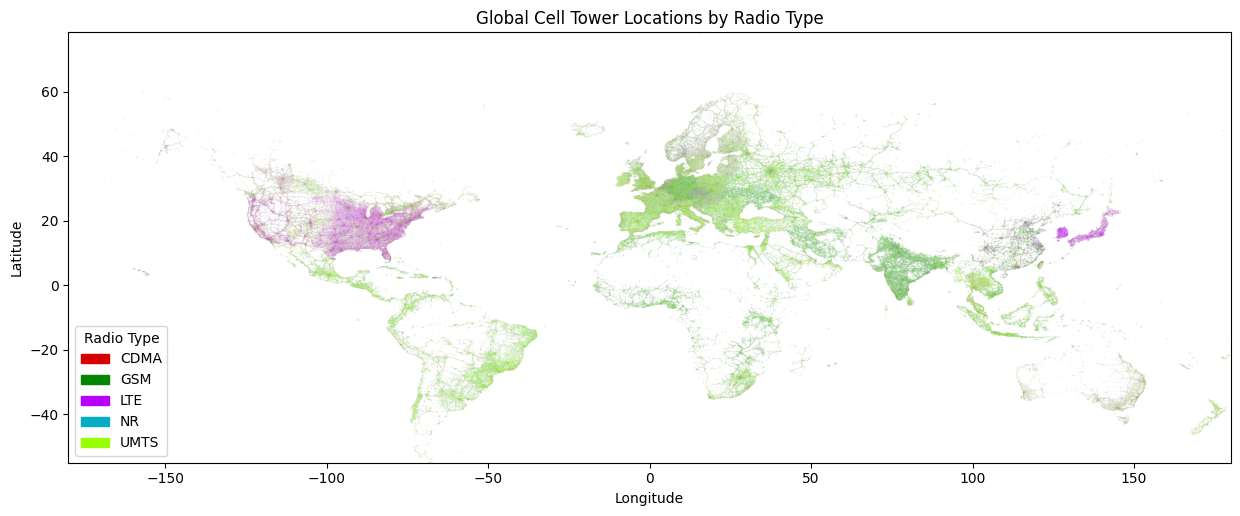

In [12]:
towers = pd.read_csv('cell_towers.csv.zst')

# Convert the 'radio' column to a categorical type
towers['radio'] = towers['radio'].astype('category')

# Convert longitude and latitude to Web Mercator format
towers['easting'], towers['northing'] = lnglat_to_meters(towers['lon'], towers['lat'])

# Define the Canvas
canvas = ds.Canvas(plot_width=1800, plot_height=1000)

# Create aggregation using datashader with categorical aggregation for 'radio'
agg = canvas.points(towers, 'easting', 'northing', ds.count_cat('radio'))

# Apply color coding using the radio type with a color map for categories
color_key = dict(zip(towers['radio'].cat.categories, cc.glasbey_light))

img = tf.shade(agg, color_key=color_key, how='log')

# Display the plot using matplotlib
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(img.to_pil(), extent=(towers['lon'].min(), towers['lon'].max(), towers['lat'].min(), towers['lat'].max()))
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Global Cell Tower Locations by Radio Type')
legend_handles = [mpatches.Patch(color=color_key[label], label=label) for label in towers['radio'].cat.categories]
ax.legend(handles=legend_handles, title='Radio Type', loc='lower left')
plt.show()